In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install geomloss[full]

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for geomloss: filename=geomloss-0.2.5-py3-none-any.whl size=32069 sha256=ec1068fed121f79aaad183b1477e724dd056152a9efd48260c79acd5189f19cd
  Stored in directory: /root/.cache/pip/wheels/4b/ca/df/9ec3005c92d24a191bee78e803b4550c58888d9d664dd7a220
  Created wheel for pykeops: filename=pykeops-2.1.2-py3-none-any.whl size=114098 sha256=7e73d70daae9db6581c21ac3ed46ee0a8c5fb556a2e7960e6766d2714d2b9e75
  Stored in directory: /root/.cache/pip/wheels/d9/9a/a0/7b726028e68017fe17329b68dad801ce3371b09d3e8742be2b
  Created wheel for keopscore: filename=keopscore-2.1.2-py3-none-any.whl size=146469 sha256=e1af45a68b334c1a91f9650affe4cea641f25d6107cba2721f0a5401071c3d5c
  Stored in directory: /ro

In [3]:
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, BatchNormalization
from keras.models import Sequential, Model
from keras.constraints import Constraint
from keras.optimizers import RMSprop, Adam
from keras.initializers import GlorotNormal
from keras.losses import BinaryCrossentropy

from pathlib import Path

In [4]:
np.random.seed(2023)

In [5]:
def genGauss(p,n=1,r=1):
    # Load the dataset
    x = []
    y = []
    for k in range(n):
        x_t, y_t = np.random.multivariate_normal([math.sin(2*k*math.pi/n), math.cos(2*k*math.pi/n)], [[0.0125, 0], [0, 0.0125]], p).T
        x.append(x_t)
        y.append(y_t)

    x=np.array(x).flatten()[:,None]
    y=np.array(y).flatten()[:,None]
    x-=np.mean(x)
    y-=np.mean(y)
    train=np.concatenate((x,y),axis=1)

    return train/(np.max(train)*r)

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def compute_grads(model, X, y, loss_fn=None):
    model.trainable = False
    with tf.GradientTape() as tape:
        logits = model(X, training=False)
        if loss_fn is None:
            loss = model.compiled_loss(y, logits)
        else:
            logits = tf.reshape(logits, tf.shape(y))
            loss = loss_fn(y, logits)
    grads = tape.gradient(loss, model.trainable_weights)
    return avg_grads(grads)

def avg_grads(grads):
    mean_grad = tf.zeros(())
    for grad in grads:
        mean_grad += tf.reduce_mean(grad)
    mean_grad /= len(grads)
    return mean_grad

class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

In [6]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    return X

In [7]:
def build_generator(z_dim):
    init = GlorotNormal(seed=0)
    model = Sequential()
    model.add(Dense(512, input_dim=z_dim, kernel_initializer=init, activation='LeakyReLU'))
    model.add(Dense(512, kernel_initializer=init, activation='LeakyReLU'))
    model.add(Dense(512, kernel_initializer=init, activation='LeakyReLU'))
    model.add(Dense(2, kernel_initializer=init, activation='linear'))
    
    return model 

def build_discriminator():
    init = GlorotNormal(seed=0)
    model = Sequential()
    model.add(Dense(512, input_dim=2, kernel_initializer=init, activation='LeakyReLU'))
    model.add(Dense(512, kernel_initializer=init, activation='LeakyReLU'))
    model.add(Dense(512, kernel_initializer=init, activation='LeakyReLU'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    model.compile(
        optimizer = Adam(learning_rate=lr),
        loss = 'binary_crossentropy'
    )
    return model


def build_critic():
    init = GlorotNormal(seed=0)
    const = ClipConstraint(0.01)
    model = Sequential()
    model.add(Dense(512, input_dim=2, kernel_initializer=init, kernel_constraint=const, activation='LeakyReLU'))
    model.add(Dense(512, kernel_initializer=init, kernel_constraint=const, activation='LeakyReLU'))
    model.add(Dense(512, kernel_initializer=init, kernel_constraint=const, activation='LeakyReLU'))
    model.add(Dense(1, kernel_initializer=init, kernel_constraint=const, activation='linear'))
    model.compile(
        optimizer=RMSprop(learning_rate=lr),
        loss=wasserstein_loss
    )
    return model

def build_gan(gen, dis):
    for layer in dis.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    model = Sequential()
    model.add(gen)
    model.add(dis)
    model.compile(
        optimizer = Adam(learning_rate=lr),
        loss = 'binary_crossentropy'
    )
    return model

def build_wgan(gen, critic):
    for layer in critic.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    model = Sequential()
    model.add(gen)
    model.add(critic)
    model.compile(
        optimizer=RMSprop(learning_rate=lr),
        loss = wasserstein_loss
    )    
    return model

In [8]:
def init_graphs():
    fig, axarr = plt.subplots(1, 3, figsize=(20,5))
    for ax in axarr:
        ax.set_xlim([-1.5,1.5])
        ax.set_ylim([-1.0,1.0])
    return fig, axarr

In [9]:
Path("/kaggle/working/data").mkdir(parents=True, exist_ok=True)

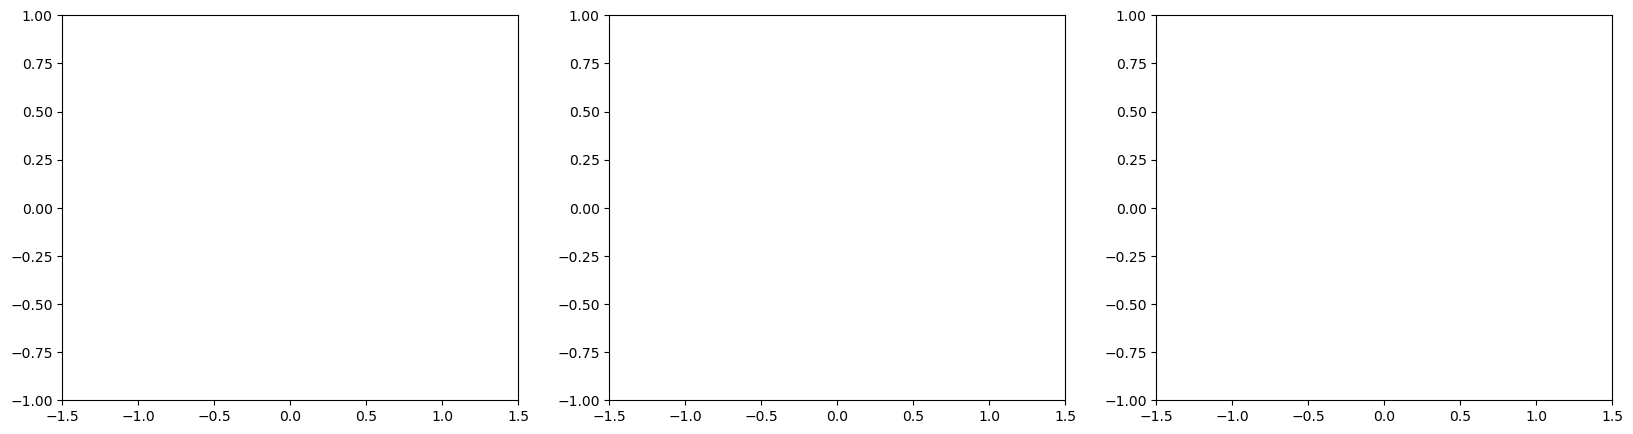

In [10]:
fig, axarr = init_graphs()
save_dir = '/kaggle/working/data'
epochs = 5000
batch_size = 64
z_dim = 2
lr = 5e-5

In [11]:
critic = build_critic()
dis = build_discriminator()

gen_gan, gen_wgan = build_generator(z_dim), build_generator(z_dim)

combined_gan = build_gan(gen_gan, dis)
combined_wgan = build_wgan(gen_wgan, critic)

In [12]:
X_train = genGauss(100, 5, 1)
np.random.shuffle(X_train)
plot_dis_loss =[]
plot_critic_loss = []
plot_gan_loss = []
plot_wgan_loss = []

In [13]:
epochs=200

for epoch in range(epochs):
    print('Epoch :', epoch)
    n_batches = int(X_train.shape[0] / batch_size)
    # record loss for each epoch
    critic_loss_epo, critic_grad_epo = list(), list()
    dis_loss_epo, dis_grad_epo = list(), list()
    gan_loss_epo,  gan_grad_epo = list(), list()
    wgan_loss_epo,  wgan_grad_epo= list(), list()
    
    # for each batch
    for _ in range(n_batches):
        dis_iter = 5

        it = 0
        critic_loss, critic_grads = list(), list()
        dis_loss, dis_grads = list(), list()
        
        # train critic and dis
        for _ in range(dis_iter):
            sample_batch = generate_real_samples(X_train, batch_size)
            Z = np.random.uniform(-1, 1, (batch_size, z_dim))
            generated_samples_gan, generated_samples_wgan = gen_gan.predict(Z), gen_wgan.predict(Z)
            
            X_gan = np.concatenate((sample_batch, generated_samples_gan))
            X_wgan = np.concatenate((sample_batch, generated_samples_wgan))
            d_y = tf.cast(np.array([1] * len(sample_batch) + [0] * batch_size),tf.float32)
            c_y = tf.cast(np.array([1] * len(sample_batch) + [-1] * batch_size),tf.float32)
            d_loss = dis.train_on_batch(X_gan, d_y)
            c_loss = critic.train_on_batch(X_wgan, c_y)
            
            critic_loss.append(c_loss)
            critic_grads.append(compute_grads(critic, X_wgan, c_y))
            dis_loss.append(d_loss)
            dis_grads.append(compute_grads(dis, X_gan, d_y))
        critic_loss_epo.append(np.mean(critic_loss))
        critic_grad_epo.append(np.mean(critic_grads))
        dis_loss_epo.append(np.mean(dis_loss))
        dis_grad_epo.append(np.mean(dis_grads))
        
        Z = np.random.uniform(-1, 1, (batch_size, z_dim))
        target = np.ones(batch_size)
        gan_loss =  combined_gan.train_on_batch(Z, target)
        wgan_loss = combined_wgan.train_on_batch(Z, target)
        gan_loss_epo.append(gan_loss)
        gan_grad_epo.append(compute_grads(combined_gan, Z, target, loss_fn=BinaryCrossentropy()))
        wgan_loss_epo.append(wgan_loss)
        wgan_grad_epo.append(compute_grads(combined_wgan, Z, target, loss_fn=wasserstein_loss))
        
    print('\n Vanilla GAN [Loss_D: {:.6f}, Loss_G: {:.6f}]'.format(np.mean(dis_loss_epo), np.mean(gan_loss_epo)))
    print('\n w-GAN [Loss_D: {:.6f}, Loss_G: {:.6f}]'.format(np.mean(critic_loss_epo), np.mean(wgan_loss_epo)))

    plot_dis_loss.append(np.mean(dis_loss_epo))
    plot_critic_loss.append(np.mean(critic_loss_epo))
    plot_gan_loss.append(np.mean(gan_loss_epo))
    plot_wgan_loss.append(np.mean(wgan_loss_epo))

    Z = np.random.uniform(-1, 1, (100, z_dim))
    gan_images = gen_gan.predict(Z)
    wgan_images = gen_wgan.predict(Z)

    fig.suptitle('Epoch: {}'.format(epoch))
    axarr[0].set_title('GAN')
    axarr[0].scatter(X_train[:, 0], X_train[:, 1], c = 'red', label = 'Real data', marker = '.')
    axarr[0].scatter(gan_images[:, 0], gan_images[:, 1], c = 'green', label = 'Fake data', marker = '.')
    axarr[0].legend(loc='upper left')

    axarr[1].set_title('w-GAN')
    axarr[1].scatter(X_train[:, 0], X_train[:, 1], c = 'red', label = 'Real data', marker = '.')
    axarr[1].scatter(wgan_images[:, 0], wgan_images[:, 1], c = 'green', label = 'Fake data', marker = '.')
    axarr[1].legend(loc='upper left')

    fig.savefig(f'/kaggle/working/data/dist_epoch{epoch}.png')
    axarr[0].clear()
    axarr[1].clear()

Epoch : 0
2/2 [==============================] - 0s 3ms/step

 Vanilla GAN [Loss_D: 0.654576, Loss_G: 0.693317]

 w-GAN [Loss_D: 0.000049, Loss_G: 0.000318]
4/4 [==============================] - 0s 2ms/step
Epoch : 1
2/2 [==============================] - 0s 4ms/step

 Vanilla GAN [Loss_D: 0.582527, Loss_G: 0.688621]

 w-GAN [Loss_D: -0.000486, Loss_G: 0.000765]
4/4 [==============================] - 0s 2ms/step
Epoch : 2
2/2 [==============================] - 0s 4ms/step

 Vanilla GAN [Loss_D: 0.517825, Loss_G: 0.690997]

 w-GAN [Loss_D: -0.001635, Loss_G: 0.001634]
4/4 [==============================] - 0s 2ms/step
Epoch : 3
2/2 [==============================] - 0s 4ms/step

 Vanilla GAN [Loss_D: 0.468253, Loss_G: 0.742039]

 w-GAN [Loss_D: -0.003107, Loss_G: 0.002406]
4/4 [==============================] - 0s 2ms/step
Epoch : 4
2/2 [==============================] - 0s 4ms/step

 Vanilla GAN [Loss_D: 0.446510, Loss_G: 0.873954]

 w-GAN [Loss_D: -0.003593, Loss_G: 0.000291]
4/4 [==

In [14]:
import imageio

frames = list()
for epoch in range(epochs):
    image = imageio.v2.imread(f'/kaggle/working/data/dist_epoch{epoch}.png')
    frames.append(image)

In [15]:
imageio.mimsave('/kaggle/working/dist.gif', # output gif
                frames,          # array of input frames
                fps = 5)         # optional: frames per second